## **MATEMÁTICA SUPERIOR**
### TRABAJO PRÁCTICO -  FINAL.
***CREADOR***
* Ignacio Javier Guridi
* Legajo : 13506

## Predicción de resultados de la Copa América
Para intentar predecir los resultados de la Copa América voy a utilizar un modelo simple de Regresión Logística que adapté de Kaggle; en dónde las principales variales para predecir los resultados serán el ranking FIFA de cada equipo, el talento de sus jugadores y el historial de enfrentamientos.

Los datos que utilicé los armé en base a datasets que obtuve de Kaggle y fui combinando datos para llegar a la dataset presentada. 

* equipos: Este dataset contiene los datos de los jugadores convocados en cada selección.

* partidos: Este dataset contine el historial de partidos en que se enfrentaron las selecciones que participan de la copa.

* copa: Este dataset contine la composición de los grupos de la Copa América.

Comencemos con el modelo...

In [1]:
# Importando las librerías que vamos a utilizar
import pandas as pd
import numpy as np
from pandasql import sqldf
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

#utilizar SQL para filtrar pandas df
query = lambda q: sqldf(q, globals())

# graficos incrustados
%matplotlib inline

In [2]:
# importando los datos
# jugadores de las selecciones 
equipos = pd.read_csv('selecciones.csv', index_col=0, encoding='latin-1', sep=";")

# completando el overall de jugadores faltantes
equipos['Overall'] = equipos['Overall'].fillna(65)

# Historial de partidos entre las selecciones
partidos = pd.read_csv('partidos.csv', index_col=0, encoding='latin-1', sep=";")

# Grupos Copa América Brasil 2019
copa = pd.read_csv('CopaAmerica.csv', index_col=0, encoding='latin-1', sep=";")
copamuestra = copa[['equipo', 'grupo', 'titulos', 'subcampeonatos', 'ranking FIFA']]
copamuestra

,equipo,grupo,titulos,subcampeonatos,ranking FIFA
1,,,,,
2,Brasil,A,8,11,3
3,Bolivia,A,1,1,63
4,Venezuela,A,0,0,29
5,Peru,A,2,0,21
6,Argentina,B,14,14,11
7,Colombia,B,1,1,12
8,Paraguay,B,2,6,36
9,Qatar,B,0,0,55
10,Uruguay,C,15,6,6


Los datos estan tomados de las estadísticas de los jugadores del videojuego FIFA19 para determinar el talento general que le corresponde a cada selección y ese número se ve reflejado en la columna Overall del dataset de equipos. Vamos a agregar ese dato a los dataset de partidos y de copa para facilitar el acceso a ese dato.

In [3]:
# Agregando el pontencial del equipo al dataset de partidos
potencial = equipos.groupby('selección').mean()['Overall']
partidos = partidos.merge(potencial, 
                        left_on=['local'], 
                        right_on=['selección'])
partidos = partidos.merge(potencial, 
                        left_on=['visitante'], 
                        right_on=['selección'], 
                        suffixes=('_local', '_visitante'))

# Agregar diferencia de potencial entre los equipos
partidos['dif_potencial'] = partidos['Overall_local'] - partidos['Overall_visitante']

# Agregando el pontencial del equipo al dataset de copa
copa = copa.merge(potencial, 
                        left_on=['equipo'], 
                        right_on=['selección'])
copa = copa.set_index(['equipo'])

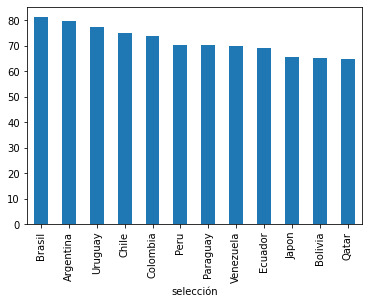

In [4]:
# Graficando el potencial de cada seleccion
# de acuerdo a la jerarquía (media) de sus jugadores
plot = potencial.sort_values( ascending=False).plot(kind='bar')

Como vemos en este gráfico...los grandes candidatos de acuerdo a la calidad de sus jugadores son Brasil, Argentina y Uruguay..ahora armemos el modelo

## Modelo

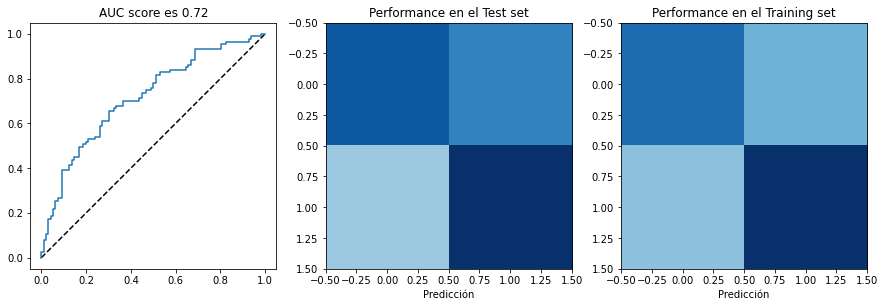

In [5]:
# Armado del modelo de regresión lineal para predecir los resultados
# los predictores a utilizar seran la diferencia del ranking fifa y el potencial
# de los jugadores de las selecciones

X, y = partidos.loc[:,['ranking_local', 'dif_ranking', 'dif_potencial']], partidos['gana_local']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

logreg = linear_model.LogisticRegression(solver='lbfgs', C=1e-5)
features = PolynomialFeatures(degree=2)
model = Pipeline([
    ('polynomial_features', features),
    ('logistic_regression', logreg)
])
model = model.fit(X_train, y_train)

# Graficos 
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score es {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test, model.predict(X_test))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 

ax.set_xlabel('Predicción')
ax.set_title('Performance en el Test set')

ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train, model.predict(X_train))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 
ax.set_xlabel('Predicción')
ax.set_title('Performance en el Training set')
plot = plt.show()

El modelo tiene una precisión del 72% no es un gran resultado...pero es decente teniendo en cuenta que los resultados del futbol no se caracterizan por ser fáciles de predecir.

continuemos ahora con la simulación de la fase de grupos

## Simulación de fase de grupos

In [6]:
# Simulando los partidos de la fase de grupos
from itertools import combinations

# margen de error para definir empate en casos parejos
margin = 0.05

copa['puntos'] = 0
copa['total_prob'] = 0

for grupo in sorted(set(copa['grupo'])):
    print('___Grupo {}:___'.format(grupo))
    for local, visitante in combinations(copa.query('grupo == "{}"'.format(grupo)).index, 2):
        print("{} vs. {}: ".format(local, visitante), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan]]), columns=X_test.columns)
        row['ranking_local'] = copa.loc[local, 'ranking FIFA']
        opp_rank = copa.loc[visitante, 'ranking FIFA']
        local_pot = copa.loc[local, 'Overall']
        opp_pot = copa.loc[visitante, 'Overall']
        row['dif_ranking'] = row['ranking_local'] - opp_rank 
        row['dif_potencial'] = local_pot - opp_pot  
        local_win_prob = model.predict_proba(row)[:,1][0]
        copa.loc[local, 'total_prob'] += local_win_prob
        copa.loc[visitante, 'total_prob'] += 1-local_win_prob
        
        # Asignando los puntos en a los equipos en el grupo
        points = 0
        if local_win_prob <= 0.5 - margin:
            print("{} gana con prob de {:.3f}".format(visitante, 1-local_win_prob))
            copa.loc[visitante, 'puntos'] += 3
        if local_win_prob > 0.5 - margin:
            points = 1
        if local_win_prob >= 0.5 + margin:
            points = 3
            copa.loc[local, 'puntos'] += 3
            print("{} gana con prob de {:.3f}".format(local, local_win_prob))
        if points == 1:
            print("empatan")
            copa.loc[local, 'puntos'] += 1
            copa.loc[visitante, 'puntos'] += 1

___Grupo A:___
Brasil vs. Bolivia: Brasil gana con prob de 0.785
Brasil vs. Venezuela: Brasil gana con prob de 0.622
Brasil vs. Peru: Brasil gana con prob de 0.591
Bolivia vs. Venezuela: Venezuela gana con prob de 0.639
Bolivia vs. Peru: Peru gana con prob de 0.667
Venezuela vs. Peru: empatan
___Grupo B:___
Argentina vs. Colombia: empatan
Argentina vs. Paraguay: Argentina gana con prob de 0.637
Argentina vs. Qatar: Argentina gana con prob de 0.765
Colombia vs. Paraguay: Colombia gana con prob de 0.573
Colombia vs. Qatar: Colombia gana con prob de 0.687
Paraguay vs. Qatar: Paraguay gana con prob de 0.655
___Grupo C:___
Uruguay vs. Ecuador: Uruguay gana con prob de 0.681
Uruguay vs. Japon: Uruguay gana con prob de 0.623
Uruguay vs. Chile: empatan
Ecuador vs. Japon: empatan
Ecuador vs. Chile: Chile gana con prob de 0.675
Japon vs. Chile: Chile gana con prob de 0.586


In [7]:
# ver posiciones de grupos
copa = copa.sort_values(by=['grupo', 'puntos', 'total_prob'], ascending=[True, False, False]).reset_index()

In [8]:
# Seleccionar quienes pasan de ronda
next_round = copa.groupby('grupo').nth([0, 1, 2]).reset_index() # primeros 3
next_round[['grupo','equipo', 'puntos']]

,grupo,equipo,puntos
0,A,Brasil,9
1,A,Peru,4
2,A,Venezuela,4
3,B,Argentina,7
4,B,Colombia,7
5,B,Paraguay,3
6,C,Uruguay,7
7,C,Chile,7
8,C,Japon,1


Ahora que ya tenemos las predicciones de quienes superarán la primera fase y continuarán compitiendo para ganar la copa. A continuacion simularemos la fase final y veremos quien se convierte en campeón!

## Simulando fase final

In [9]:
# Armo los cruces...el peor 3ro queda afuera de cuartos
cruces = [0,6,1,4,3,7,5,2]

next_round = next_round.loc[cruces]
next_round = next_round.set_index('equipo')

In [10]:
# Simulo rondas finales
finales = ['cuartos de final', 'semifinal', 'final']

copa = copa.set_index(['equipo'])

for f in finales:
    print("___Ronda {}___".format(f))
    iterations = int(len(next_round) / 2)
    winners = []

    for i in range(iterations):
        local = next_round.index[i*2]
        visitante = next_round.index[i*2+1]
        print("{} vs. {}: ".format(local,
                                   visitante), 
                                   end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan]]), columns=X_test.columns)
        row['ranking_local'] = copa.loc[local, 'ranking FIFA']
        opp_rank = copa.loc[visitante, 'ranking FIFA']
        local_pot = copa.loc[local, 'Overall']
        opp_pot = copa.loc[visitante, 'Overall']
        row['dif_ranking'] = row['ranking_local'] - opp_rank 
        row['dif_potencial'] = local_pot - opp_pot  
        local_win_prob = model.predict_proba(row)[:,1][0]
        copa.loc[local, 'total_prob'] += local_win_prob
        copa.loc[visitante, 'total_prob'] += 1-local_win_prob

        local_win_prob = model.predict_proba(row)[:,1][0]
        if model.predict_proba(row)[:,1] <= 0.5:
            print("{0} gana con prob de {1:.3f}".format(visitante, 1-local_win_prob))
            winners.append(visitante)
        else:
            print("{0} gana con prob de {1:.3f}".format(local, local_win_prob))
            winners.append(local)
                
    next_round = next_round.loc[winners]
    print("\n")

___Ronda cuartos de final___
Brasil vs. Uruguay: Brasil gana con prob de 0.512
Peru vs. Colombia: Colombia gana con prob de 0.540
Argentina vs. Chile: Argentina gana con prob de 0.532
Paraguay vs. Venezuela: Venezuela gana con prob de 0.503


___Ronda semifinal___
Brasil vs. Colombia: Brasil gana con prob de 0.541
Argentina vs. Venezuela: Argentina gana con prob de 0.616


___Ronda final___
Brasil vs. Argentina: Brasil gana con prob de 0.513




Bueno aca como podemos ver nos la la prediccion que va a ganar brasil ya que tiene sentido por la calidad de jugadores que tiene en ese año tomando las medias del fifa 19. Si queremos obtener otros resultados podemos cambiar los cruces como tambien modificar el dataset ya sea actualizandolo como creando uno nuevo.